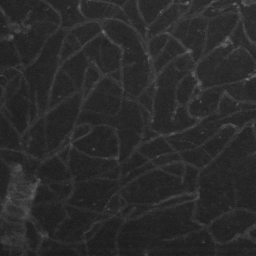

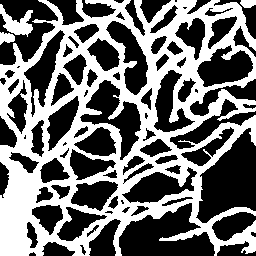

In [22]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset
import json

root = Path('../data/VessMAP')
img = Image.open(root/'images/356.tiff')
target = Image.open(root/'annotator1/labels/356.png')

display(img, target)

torch.uint8
tensor([  0, 255], dtype=torch.uint8)


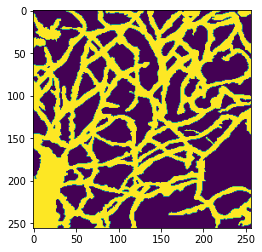

In [23]:
img = torch.from_numpy(np.array(img))/255
target = torch.from_numpy(np.array(target))
print(target.dtype)
print(torch.unique(target))
plt.imshow(target)

torch.Size([256, 256, 1])


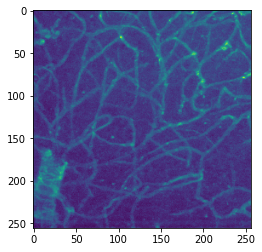

In [24]:
def show_mask(img, target, alpha=0.3):

    target_bin = (target==1).int()
    target_bin = target_bin.unsqueeze(2)
    img = img.unsqueeze(2)
    mask = img*(1-alpha) + target_bin*alpha
    print(mask.shape)
    plt.imshow(mask)

show_mask(img, target)

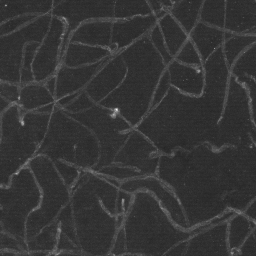

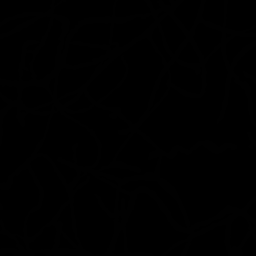

In [47]:
class VessMAP(Dataset):

    def __init__(self, root, transforms=None, ignore_val=2):

        root = Path(root)
        images_folder = root / "images"
        segs_folder = root / "annotator1/labels"
        anns_file = root / "annotator1/measures.json"

        images = []
        segs = []

        ann_file = open(anns_file)
        dados = json.load(ann_file)
        names = dados.keys()
        for name in names:
            images.append(images_folder/f'{name}.tiff')
            segs.append(segs_folder/f'{name}.png')
            
        self.images = images
        self.segs = segs
        self.transforms = transforms
        self.ignore_val = ignore_val

    def __getitem__(self, idx, apply_transform=True):
        image = Image.open(self.images[idx]).convert("RGB")
        target_or = Image.open(self.segs[idx])
        target_np = np.array(target_or)
        target_np[target_np==255] = 1
        target = Image.fromarray(target_np, mode="L")
        
        if self.transforms and apply_transform:
            image, target = self.transforms(image, target)

        return image, target
    
    def __len__(self):
        return len(self.images)

ds = VessMAP(root)
display(*ds[87])

In [48]:
%%time
import numpy as np

def get_statistics(ds):
    n = len(ds)
    mean = np.zeros(3)
    std = np.zeros(3)
    classes = np.array([0,0])
    shapes = np.array([np.inf, -1])

    for img, target in ds:
        img_np = np.array(img)
        mean += np.mean(img_np, axis=(0,1))
        std += np.std(img_np, axis=(0,1))

        shapes[0] = min([shapes[0], img_np.shape[0], img_np.shape[1]])
        shapes[1] = max([shapes[1], img_np.shape[0], img_np.shape[1]])

    mean /= n
    std /= n

    return mean, std, classes, shapes

print(get_statistics(ds))

(array([33.30908798, 33.30908798, 33.30908798]), array([10.86453397, 10.86453397, 10.86453397]), array([0, 0]), array([256., 256.]))
CPU times: user 871 ms, sys: 20 ms, total: 891 ms
Wall time: 892 ms
